# **Primer parcial procesamiento de datos a gran escala**

## Pontificia Universidad Javeriana

### Autores: 
- Diego Alejandro Jara Rojas.
- Juan Felipe González Quintero

Fecha de Inicio: 03 - 09 - 2025

Fecha actual: 03 - 09 - 2025


## **Problemática**
Hemos sido contratados por una compañía de fútbol para la creación de un nuevo equipo de fútbol en la liga inglesa. Se tiene el interés de conocer un poco más los equipos y resultados que se obtuvieron en la liga de 17-18, para así poder tener una mejor idea de que tipos de jugadores se preferiría contratar y que estilo de juego quiere que tenga su equipo. Para esto ustedes cuentan con la información de los resultados por partido, como también las estadísticas obtenidas por los equipos y jugadores; todo lo anterior en el sistema de ficheros de Databricks (dbfs).

## **Objetivo**
Realizar un análisis de información con PySpark sobre partidos, equipos y jugadores de la liga inglesa en la temporada 17-18, con la finalidad de encontrar los mejores jugadores y el estilo de juego ideal para la comformación de un nuevo equipo de futbol.

## **Metodología**
1. Importación de los datos desde el sistema de archivos de databricks DBFS (Datos en diferentes formatos).

2. Descripción de las variables importantes de los conjuntos de datos.

3. Reporte de calidad de datos.

4. Preprocesamiento y limpieza de valores nulos, cambio de datos, EDA, medidas estadísticas.

5. Generación de visualizaciones gráficas de las diferentes variables.

6. Presentación de hallazagos encontrados en el estudio de los datos.

# 1. Importación de datos

### Importacion de librerias

In [0]:
%pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 134.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2022.1
    Not uninstalling tzdata at /databricks/python3/lib/python3.11/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-71f0bf00-a9cd-455e-aac8-a01323db752f
    Can't uninstall 'tzdata'. No files were found to uninstall.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Not uninstalling numpy at /databricks/python3/lib/python3.11/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-71f0bf00-a9cd-455e-aac8-a01323db752f
    Can't uninstall 'numpy'.

In [0]:
###--> BIBLIOTECAS INICIALES
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json


#Bibliotecas especializadas
from pylab import *

In [0]:
#Bibliotecas de Contexto PySpark

#Busqueda e inicializacion para pyspark
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.window import Window


from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

### Creación sesión PySpark

In [0]:
### Creación de la sesión Spark
 
spark = SparkSession.builder.getOrCreate()

### Leer archivos CSV a Dataframes

In [0]:

# Cargar los archivos csv 
## Dataframe con informacion de jugadores
df00 = spark.read.format('csv').option('inferSchema', True).option('header', True).load(f'/Volumes/workspace/default/datosparcial/jugadores.csv')
##Dataframe con información de resultados de partidos de futbol
df10 = spark.read.format('csv').option('inferSchema', True).option('header', True).load(f'/Volumes/workspace/default/datosparcial/resultados_futbol.csv')

#Mostrar datos
df00.show(5)
df10.show(5)

+-----------------+-------+---+--------+------------+------------+----------+---------+-------+----------+------+--------------+-----------+-------+-------+--------+-----------+
|             name|   club|age|position|position_cat|market_value|page_views|fpl_value|fpl_sel|fpl_points|region|   nationality|new_foreign|age_cat|club_id|big_club|new_signing|
+-----------------+-------+---+--------+------------+------------+----------+---------+-------+----------+------+--------------+-----------+-------+-------+--------+-----------+
|   Alexis Sanchez|Arsenal| 28|      LW|           1|        65.0|      4329|     12.0| 17.10%|       264|     3|         Chile|          0|      4|      1|       1|          0|
|       Mesut Ozil|Arsenal| 28|      AM|           1|        50.0|      4395|      9.5|  5.60%|       167|     2|       Germany|          0|      4|      1|       1|          0|
|        Petr Cech|Arsenal| 35|      GK|           4|         7.0|      1529|      5.5|  5.90%|       134|    

### Leer archivos Json y convertirlos a CSV

In [0]:
#Convertir a CSV los datos del JSON de los equipos

file = open('/Volumes/workspace/default/datosparcial/temporadas.json', encoding="utf8")

data = json.load(file)
lista = []
HomeTeam = True

# Iterador para recorrer keys del primer nivel del JSON
iter1 = iter(data)
while True:
    try:
        X = next(iter1)
    except StopIteration:
        break

    # Iterador para recorrer keys del segundo nivel del JSON
    iter2 = iter(data[str(X)])
    while True:
        try:
            Y = next(iter2)
        except StopIteration:
            break

        dicc = {}
        team_details = data[str(X)][str(Y)]['team_details']
        aggregate_stats = data[str(X)][str(Y)]['aggregate_stats']
        key, value = 'match_id', X  # Cambiamos el nombre de la columna 'match' a 'match_id'
        team_details[key] = value

        if HomeTeam:
            key, value = "team", "L"
            HomeTeam = False
        else:
            key, value = "team", "V"
            HomeTeam = True

        team_details[key] = value
        dicc.update(team_details)
        dicc.update(aggregate_stats)
        lista.append(dicc)
        del dicc

data = pd.DataFrame(lista)

# Reordenar columnas
columnas_a_reordenar = ['match_id', 'team_id', 'team_name', 'team']
nuevas_columnas = columnas_a_reordenar + [col for col in data.columns if col not in columnas_a_reordenar]

data = data[nuevas_columnas]
# Se guarda el CSV en el volumen
data.to_csv("/Volumes/workspace/default/datosparcial/EquiposJSON.csv", index=False)


In [0]:
#Convertir a CSV los datos del JSON de los jugadores

# Abre el archivo JSON
with open('/Volumes/workspace/default/datosparcial/temporadas.json', encoding="utf8") as file:
    data = json.load(file)

# Lista para almacenar los diccionarios de datos de los jugadores
lista = []

# Itera a través de los datos del archivo JSON
for X in data:
    for Y in data[str(X)]:
        for Z in data[str(X)][str(Y)]['Player_stats']:
            dicc = {}

            # Obtén los detalles del jugador y las estadísticas del partido
            player_details = data[str(X)][str(Y)]['Player_stats'][str(Z)]['player_details']
            player_stats = data[str(X)][str(Y)]['Player_stats'][str(Z)]['Match_stats']

            # Agrega los datos al diccionario
            dicc.update(player_details)
            dicc.update(player_stats)

            # Agrega información adicional al diccionario
            dicc['match'] = X
            dicc['team'] = Y
            dicc['player_name'] = str(Z)

            # Agrega el diccionario a la lista
            lista.append(dicc)

# Crea un DataFrame a partir de la lista de diccionarios
df = pd.DataFrame(lista)

# Reordenar columnas
columnas_a_reordenar = ['match', 'team']
nuevas_columnas = columnas_a_reordenar + [col for col in df.columns if col not in columnas_a_reordenar]

df = df[nuevas_columnas]

# Guarda el DataFrame en un archivo CSV
df.to_csv("/Volumes/workspace/default/datosparcial/JugadoresJSON.csv", index=False)



### Leer archivos CSV del Json y convertirlos a Dataframes

In [0]:
## Dataframes de Equipos del JSON
df20 = spark.read.format('csv').option('inferSchema', True).option('header', True).load(f'/Volumes/workspace/default/datosparcial/EquiposJSON.csv')

## Dataframes de Jugadores del JSON
df30 = spark.read.format('csv').option('inferSchema', True).option('header', True).load(f'/Volumes/workspace/default/datosparcial/JugadoresJSON.csv')

#Mostrar contenido
df20.show(5)
df30.show(5)

+--------+-------+------------+----+----------------+----------+-----------+-----------------+-----------+------------+-----------+---------------------+-------------+----------+------------+---------------+-------------+-------------------+--------------------+----------+-------------+-----------------+------------+--------------+-----------------+------------------+---------------+-----+------------+------------------+-------------------+-------------+-------------+----------------+-------------------+-----------------+----------------+----------------+------------------+-------------------+------------------+--------------+--------------------+------------+-------------+
|match_id|team_id|   team_name|team|     team_rating|      date|won_corners|att_sv_low_centre|won_contest|total_tackle|aerial_lost|possession_percentage|accurate_pass|total_pass|total_throws|shot_off_target|total_offside|blocked_scoring_att|ontarget_scoring_att|aerial_won|att_miss_left|total_scoring_att|fk_foul_lost

# 2. Preprocesamiento y limpieza de valores nulos, cambio de datos, EDA, medidas estadísticas.

## A. Descripción de variables del dataframe de Equipos

In [0]:
# Dataframe de jugadores
df00.show(10)

+-----------------+-------+---+--------+------------+------------+----------+---------+-------+----------+------+--------------+-----------+-------+-------+--------+-----------+
|             name|   club|age|position|position_cat|market_value|page_views|fpl_value|fpl_sel|fpl_points|region|   nationality|new_foreign|age_cat|club_id|big_club|new_signing|
+-----------------+-------+---+--------+------------+------------+----------+---------+-------+----------+------+--------------+-----------+-------+-------+--------+-----------+
|   Alexis Sanchez|Arsenal| 28|      LW|           1|        65.0|      4329|     12.0| 17.10%|       264|     3|         Chile|          0|      4|      1|       1|          0|
|       Mesut Ozil|Arsenal| 28|      AM|           1|        50.0|      4395|      9.5|  5.60%|       167|     2|       Germany|          0|      4|      1|       1|          0|
|        Petr Cech|Arsenal| 35|      GK|           4|         7.0|      1529|      5.5|  5.90%|       134|    

In [0]:
#Columnas 
df00.columns

['name',
 'club',
 'age',
 'position',
 'position_cat',
 'market_value',
 'page_views',
 'fpl_value',
 'fpl_sel',
 'fpl_points',
 'region',
 'nationality',
 'new_foreign',
 'age_cat',
 'club_id',
 'big_club',
 'new_signing']

En el dataframe de equipos se contienen las siguientes variables:
- **NAME:** Nombre del jugador.
- **CLUB:** Club al que pertenece el jugador.
- **AGE:** Edad del jugador.
- **POSITION:** Posición en la que juega el jugador.
- **POSITION CATEGORY:** Número categorico que se le asigna a cada posición, dependiendo del lugar que ocupan en la cancha.
- **MARKET VALUE:** Valor aproximado que se le asigna un jugador de futbol, tiene en cuenta cosas como edad, rendimiento, etc.
- **PAGE VIEWS:** Cantidad de vistas que tiene su perfil de jugador.
- **FPL VALUE:** Costo en millones de libras esterlinas, del jugador en la Fantasy Premier League. 
- **FPL SEL:** Porcentaje de usuario de la Fantasy Premier League que tienen al jugador en su equipo.
- **FPL POINTS:** Puntaje acumulado del jugador en la temporada según el sistema Fantasy.
- **REGIÓN:** Categoría geográfica o de origen de los jugadores (1 = UK, 2 = Europa, 3 = América, 4 = Resto del mundo).
- **NATIONALITY:** Indica el pais de Nacimiento.
- **NEW FOREIGN:** Indica si es un extranjero que acaba de llegar a la Premier League.
- **AGE CATEGORY:** Categoria que divide la edades en rangos.
- **CLUB ID:** Identificador del club.
- **BIG CLUB:** Indica si el club es considerado importante dentro de la Premier League.
- **NEW SIGNING:** Indica si el jugador es un nuevo fichaje de la temporada.

## B. Descripción de variables del dataframe de resultados de partidos 

In [0]:
df10.show(10)

+-------+-------------------+----------------+--------------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
| Season|           DateTime|        HomeTeam|      AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|Referee| HS| AS|HST|AST| HC| AC| HF| AF| HY| AY| HR| AR|
+-------+-------------------+----------------+--------------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|1993-94|1993-08-14 00:00:00|         Arsenal|      Coventry|   0|   3|  A|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14 00:00:00|     Aston Villa|           QPR|   4|   1|  H|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14 00:00:00|         Chelsea|     Blackburn|   1|   2|  A|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14 00:00:00|       Liverpool|Sheffield Weds|   2|   0|  H|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA

In [0]:
#Columnas 
df10.columns

['Season',
 'DateTime',
 'HomeTeam',
 'AwayTeam',
 'FTHG',
 'FTAG',
 'FTR',
 'HTHG',
 'HTAG',
 'HTR',
 'Referee',
 'HS',
 'AS',
 'HST',
 'AST',
 'HC',
 'AC',
 'HF',
 'AF',
 'HY',
 'AY',
 'HR',
 'AR']

En el dataframe de partidos se contienen las siguientes variables:

- **Season:** Temporada en la que se jugo el partido.
- **DateTime:** Fecha y hora del partido.
- **HomeTeam:** Equipo local.
- **AwayTeam:** Equipo visitante.
- **FTHG:** Goles del local al final del partido.
- **FTAG:** Goles del visitante al final del partido.
- **FTR:** Resultado al final del partido (H - Gana el local, A - Gana el visitante, D - Empate)
- **HTHG:** Goles del local al descanso.
- **HTAG:** Goles del visitante al descanso.
- **HTR:** Resultado parcial, en el descanso.
- **Referee:** Arbitro central del partido.
- **HS:** Tiros totales del equipo local.
- **AS:** Tiros totales del equipo visitante.
- **HST:** Tiros a puerta del local.
- **AST:** Tiros a puerta del visitante.
- **HC:** Saque de esquina del local. 
- **AC:** Saque de esquina del visitante.
- **HF:** Faltas cometidas por el local.
- **AF:** Faltas cometidas por el visitante.
- **HY:** Tarjetas amarillas al local.
- **AY:** Tarjetas amarillas al visitante.
- **HR:** Tarjestas rojas al local.
- **AR:** Tarjetas rojas al visitante.

## C. Descripción de variables del dataframe de temporadas - Equipos

In [0]:
df20.show(10)

+--------+-------+------------+----+----------------+----------+-----------+-----------------+-----------+------------+-----------+---------------------+-------------+----------+------------+---------------+-------------+-------------------+--------------------+----------+-------------+-----------------+------------+--------------+-----------------+------------------+---------------+-----+------------+------------------+-------------------+-------------+-------------+----------------+-------------------+-----------------+----------------+----------------+------------------+-------------------+------------------+--------------+--------------------+------------+-------------+
|match_id|team_id|   team_name|team|     team_rating|      date|won_corners|att_sv_low_centre|won_contest|total_tackle|aerial_lost|possession_percentage|accurate_pass|total_pass|total_throws|shot_off_target|total_offside|blocked_scoring_att|ontarget_scoring_att|aerial_won|att_miss_left|total_scoring_att|fk_foul_lost

In [0]:
#Columnas 
df20.columns

['match_id',
 'team_id',
 'team_name',
 'team',
 'team_rating',
 'date',
 'won_corners',
 'att_sv_low_centre',
 'won_contest',
 'total_tackle',
 'aerial_lost',
 'possession_percentage',
 'accurate_pass',
 'total_pass',
 'total_throws',
 'shot_off_target',
 'total_offside',
 'blocked_scoring_att',
 'ontarget_scoring_att',
 'aerial_won',
 'att_miss_left',
 'total_scoring_att',
 'fk_foul_lost',
 'att_miss_right',
 'att_goal_low_left',
 'att_goal_low_right',
 'att_sv_low_left',
 'goals',
 'att_pen_goal',
 'att_sv_high_centre',
 'att_goal_low_centre',
 'att_miss_high',
 'att_post_left',
 'post_scoring_att',
 'att_miss_high_right',
 'att_sv_high_right',
 'att_sv_low_right',
 'att_sv_high_left',
 'att_miss_high_left',
 'att_goal_high_right',
 'att_goal_high_left',
 'att_post_right',
 'att_goal_high_centre',
 'penalty_save',
 'att_post_high']

En el dataframe de temporadas - Equipos, las variables más importantes son las siguientes:

- **match_id:** ID del partido al que se asocia la información.
- **team_id:** ID del equipo participante del partido.
- **team_rating:** Puntuación general del equipo en el partido.
- **possession_percentage:** Porcentaje de posesión de balón durante el partido del equipo.
- **goals:** Goles anotados por el equipo durante el partido.
- **accurate_pass:** Número de pases acertados por el equipo durante el partido.

## D. Descripción de variables del dataframe de temporadas - Jugadores

In [0]:
df30.show(10)

+-------+----+---------+--------------------+---------------------+--------------------+-------------+---------------+-------+-----+----------+---------------+-------------+----------+-----------+-----+-----------------+------------+-----------+----------------+-------------------+----------------+-----+------------+-----------+--------------+-----------+------------------+----------------+-------------+--------+------------------+---------+---------------+--------------+------------+------------+------------+
|  match|team|player_id|         player_name|player_position_value|player_position_info|player_rating|good_high_claim|touches|saves|total_pass|formation_place|accurate_pass|aerial_won|aerial_lost|fouls|total_scoring_att|total_tackle|won_contest|penalty_conceded|blocked_scoring_att|man_of_the_match|goals|att_pen_goal|goal_assist|six_yard_block|yellow_card|error_lead_to_goal|post_scoring_att|second_yellow|red_card|clearance_off_line|own_goals|last_man_tackle|att_pen_target|penalty_

In [0]:
df30.columns

['match',
 'team',
 'player_id',
 'player_name',
 'player_position_value',
 'player_position_info',
 'player_rating',
 'good_high_claim',
 'touches',
 'saves',
 'total_pass',
 'formation_place',
 'accurate_pass',
 'aerial_won',
 'aerial_lost',
 'fouls',
 'total_scoring_att',
 'total_tackle',
 'won_contest',
 'penalty_conceded',
 'blocked_scoring_att',
 'man_of_the_match',
 'goals',
 'att_pen_goal',
 'goal_assist',
 'six_yard_block',
 'yellow_card',
 'error_lead_to_goal',
 'post_scoring_att',
 'second_yellow',
 'red_card',
 'clearance_off_line',
 'own_goals',
 'last_man_tackle',
 'att_pen_target',
 'penalty_save',
 'att_pen_miss',
 'att_pen_post']

En el dataframe de Temporadas - Jugadores se contienen las siguientes variables:
- **match:** ID del partido.
- **team:** ID del equipo.
- **player_name:** Nombre del jugador.
- **player_position_info:** Posición que juega el jugador.
- **player_rating:** Calificación del jugador en ese partido.
- **won_contest:** Cantidad de duelos individuales ganados por un jugador durante el partido.
- **man_of_the_match:** Indicador si fue elegido mejor jugador del partido (1).


#3. Reporte de calidad de datos

### Reporte de calidad del dataframe de jugadores

In [0]:
#Ahora se requiere conocer la estadísiticas de las diferentes columnas del dataframe de jugadores
for valor in df00.columns:
  df00.describe([valor]).show()

+-------+------------------+
|summary|              name|
+-------+------------------+
|  count|               461|
|   mean|              NULL|
| stddev|              NULL|
|    min|   Aaron Cresswell|
|    max|Åukasz FabiaÅ„ski|
+-------+------------------+

+-------+--------+
|summary|    club|
+-------+--------+
|  count|     461|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|West+Ham|
+-------+--------+

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|              461|
|   mean|26.80477223427332|
| stddev| 3.96189170370961|
|    min|               17|
|    max|               38|
+-------+-----------------+

+-------+--------+
|summary|position|
+-------+--------+
|  count|     461|
|   mean|    NULL|
| stddev|    NULL|
|    min|      AM|
|    max|      SS|
+-------+--------+

+-------+------------------+
|summary|      position_cat|
+-------+------------------+
|  count|               461|
|   mean| 2.1800433839479

In [0]:
#Visualización de datos nulos, faltantes o imposibles en el dataframe de jugadores.
## Si los valores de la columna son String busca cadenas vacías "" o valores "NA", si la columna contiene
## valores de otros tipos busca valores imposibles.
df00.select([F.count(F.when((F.col(c).isNull()) | ((F.col(c) == "") | (F.col(c) == "NA") if dict(df00.dtypes)[c] == 'string' else F.isnan(c)), c)).alias(c) for c in df00.columns]).show()

+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|name|club|age|position|position_cat|market_value|page_views|fpl_value|fpl_sel|fpl_points|region|nationality|new_foreign|age_cat|club_id|big_club|new_signing|
+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|   0|   0|  0|       0|           0|           0|         0|        0|      0|         0|     1|          0|          0|      0|      0|       0|          0|
+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+



### Reporte de calidad del dataframe de resultados de partidos

In [0]:
#Ahora se requiere conocer la estadísiticas de las diferentes columnas del dataframe de resultados de partidos
for valor in df10.columns:
  df10.describe([valor]).show()

+-------+-------+
|summary| Season|
+-------+-------+
|  count|  11113|
|   mean|   NULL|
| stddev|   NULL|
|    min|1993-94|
|    max|2021-22|
+-------+-------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-------+--------+
|summary|HomeTeam|
+-------+--------+
|  count|   11113|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|  Wolves|
+-------+--------+

+-------+--------+
|summary|AwayTeam|
+-------+--------+
|  count|   11113|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|  Wolves|
+-------+--------+

+-------+------------------+
|summary|              FTHG|
+-------+------------------+
|  count|             11113|
|   mean| 1.518221902276613|
| stddev|1.3019811033373492|
|    min|                 0|
|    max|                 9|
+-------+------------------+

+-------+-----------------+
|summary|             FTAG|
+-------+-----------------+
|  count|            11113|
|   mean|1.141455952488077|


In [0]:
# Visualización de datos nulos, faltantes o imposibles en el dataframe de resultados.
# Si los valores de la columna son String busca cadenas vacías "" o valores "NA", si la columna contiene
# valores de tipos double o float busca valores imposibles.
df10.select([F.count(F.when(F.col(c).isNull() | ((F.col(c) == "") | (F.col(c) == "NA") if dict(df10.dtypes)[c] == 'string' else (F.isnan(c) if dict(df10.dtypes)[c] in ['double', 'float'] else False)), c )).alias(c) for c in df10.columns]).show()

+------+--------+--------+--------+----+----+---+----+----+---+-------+----+----+----+----+----+----+----+----+----+----+----+----+
|Season|DateTime|HomeTeam|AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|Referee|  HS|  AS| HST| AST|  HC|  AC|  HF|  AF|  HY|  AY|  HR|  AR|
+------+--------+--------+--------+----+----+---+----+----+---+-------+----+----+----+----+----+----+----+----+----+----+----+----+
|     0|       0|       0|       0|   0|   0|  0| 924| 924|924|   2824|2824|2824|2824|2824|2824|2824|2824|2824|2824|2824|2824|2824|
+------+--------+--------+--------+----+----+---+----+----+---+-------+----+----+----+----+----+----+----+----+----+----+----+----+



### Reporte de calidad del dataframe de temporadas - Equipos

In [0]:
#Ahora se requiere conocer la estadísiticas de las diferentes columnas del dataframe de temporadas - equipos
for valor in df20.columns:
  df20.describe([valor]).show()

+-------+------------------+
|summary|          match_id|
+-------+------------------+
|  count|               760|
|   mean|         1190363.5|
| stddev|109.76841114055298|
|    min|           1190174|
|    max|           1190553|
+-------+------------------+

+-------+-----------------+
|summary|          team_id|
+-------+-----------------+
|  count|              760|
|   mean|            93.05|
| stddev|81.87226224691857|
|    min|               13|
|    max|              259|
+-------+-----------------+

+-------+---------+
|summary|team_name|
+-------+---------+
|  count|      760|
|   mean|     NULL|
| stddev|     NULL|
|    min|  Arsenal|
|    max| West Ham|
+-------+---------+

+-------+----+
|summary|team|
+-------+----+
|  count| 760|
|   mean|NULL|
| stddev|NULL|
|    min|   L|
|    max|   V|
+-------+----+

+-------+-------------------+
|summary|        team_rating|
+-------+-------------------+
|  count|                760|
|   mean|  6.779921467786607|
| stddev|0.3776833

In [0]:
# Visualización de datos nulos, faltantes o imposibles en el dataframe de resultados de partidos.
# Si los valores de la columna son String busca cadenas vacías "" o valores "NA", si la columna contiene
# valores de tipos double o float busca valores imposibles.
df20.select([F.count(F.when(F.col(c).isNull() | ((F.col(c) == "") | (F.col(c) == "NA") if dict(df20.dtypes)[c] == 'string' else (F.isnan(c) if dict(df20.dtypes)[c] in ['double', 'float'] else False)), c )).alias(c) for c in df20.columns]).show()

+--------+-------+---------+----+-----------+----+-----------+-----------------+-----------+------------+-----------+---------------------+-------------+----------+------------+---------------+-------------+-------------------+--------------------+----------+-------------+-----------------+------------+--------------+-----------------+------------------+---------------+-----+------------+------------------+-------------------+-------------+-------------+----------------+-------------------+-----------------+----------------+----------------+------------------+-------------------+------------------+--------------+--------------------+------------+-------------+
|match_id|team_id|team_name|team|team_rating|date|won_corners|att_sv_low_centre|won_contest|total_tackle|aerial_lost|possession_percentage|accurate_pass|total_pass|total_throws|shot_off_target|total_offside|blocked_scoring_att|ontarget_scoring_att|aerial_won|att_miss_left|total_scoring_att|fk_foul_lost|att_miss_right|att_goal_low

### Reporte de calidad del dataframe de temporadas - Jugadores

In [0]:
#Ahora se requiere conocer la estadísiticas de las diferentes columnas del dataframe de temporadas - equipos
for valor in df30.columns:
  df30.describe([valor]).show()

+-------+------------------+
|summary|             match|
+-------+------------------+
|  count|             13675|
|   mean| 1190363.506252285|
| stddev|109.71307940913249|
|    min|           1190174|
|    max|           1190553|
+-------+------------------+

+-------+-----------------+
|summary|             team|
+-------+-----------------+
|  count|            13675|
|   mean|93.04387568555758|
| stddev|81.82597092854478|
|    min|               13|
|    max|              259|
+-------+-----------------+

+-------+-----------------+
|summary|        player_id|
+-------+-----------------+
|  count|            13675|
|   mean|87801.52987202925|
| stddev|81854.63725526667|
|    min|              188|
|    max|           357427|
+-------+-----------------+

+-------+---------------+
|summary|    player_name|
+-------+---------------+
|  count|          13675|
|   mean|           NULL|
| stddev|           NULL|
|    min|Aaron Cresswell|
|    max|  Álvaro Morata|
+-------+---------------

In [0]:
# Visualización de datos nulos, faltantes o imposibles en el dataframe de temporadas - Jugadores.
# Si los valores de la columna son String busca cadenas vacías "" o valores "NA", si la columna contiene
# valores de tipos double o float busca valores imposibles.
df30.select([F.count(F.when(F.col(c).isNull() | ((F.col(c) == "") | (F.col(c) == "NA") if dict(df30.dtypes)[c] == 'string' else (F.isnan(c) if dict(df30.dtypes)[c] in ['double', 'float'] else False)), c )).alias(c) for c in df30.columns]).show()

+-----+----+---------+-----------+---------------------+--------------------+-------------+---------------+-------+-----+----------+---------------+-------------+----------+-----------+-----+-----------------+------------+-----------+----------------+-------------------+----------------+-----+------------+-----------+--------------+-----------+------------------+----------------+-------------+--------+------------------+---------+---------------+--------------+------------+------------+------------+
|match|team|player_id|player_name|player_position_value|player_position_info|player_rating|good_high_claim|touches|saves|total_pass|formation_place|accurate_pass|aerial_won|aerial_lost|fouls|total_scoring_att|total_tackle|won_contest|penalty_conceded|blocked_scoring_att|man_of_the_match|goals|att_pen_goal|goal_assist|six_yard_block|yellow_card|error_lead_to_goal|post_scoring_att|second_yellow|red_card|clearance_off_line|own_goals|last_man_tackle|att_pen_target|penalty_save|att_pen_miss|att_

# 4. Preprocesamiento y limpieza de valores nulos, cambio de datos, EDA, medidas estadísticas.

## Selecciónar columnas relevantes

### Columnas relevantes jugadores

In [0]:
### Dataframe de jugadores
df01 = df00.drop('position_cat', 'page_views', 'fpl_sel', 'fpl_points', 'region', 'nationality', 'new_foreign', 'age_cat', 'club_id', 'big_club', 'new_signing')

df01.show(10)

+-----------------+-------+---+--------+------------+---------+
|             name|   club|age|position|market_value|fpl_value|
+-----------------+-------+---+--------+------------+---------+
|   Alexis Sanchez|Arsenal| 28|      LW|        65.0|     12.0|
|       Mesut Ozil|Arsenal| 28|      AM|        50.0|      9.5|
|        Petr Cech|Arsenal| 35|      GK|         7.0|      5.5|
|     Theo Walcott|Arsenal| 28|      RW|        20.0|      7.5|
|Laurent Koscielny|Arsenal| 31|      CB|        22.0|      6.0|
|  Hector Bellerin|Arsenal| 22|      RB|        30.0|      6.0|
|   Olivier Giroud|Arsenal| 30|      CF|        22.0|      8.5|
|    Nacho Monreal|Arsenal| 31|      LB|        13.0|      5.5|
| Shkodran Mustafi|Arsenal| 25|      CB|        30.0|      5.5|
|       Alex Iwobi|Arsenal| 21|      LW|        10.0|      5.5|
+-----------------+-------+---+--------+------------+---------+
only showing top 10 rows




Se seleccionaron las columnas name, club, age, position, market_value y fpl_value debido a que estas permiten caracterizar de manera integral a los jugadores y facilitan el análisis de su rendimiento y valor en el mercado:

- **name y club:** Identifican al jugador y al equipo al que pertenece, lo cual es fundamental para contextualizar los resultados y posibilitar comparaciones entre clubes.

- **age:** La edad es un factor clave en el desempeño y la proyección futura de un jugador, ya que influye en su condición física, madurez táctica y valor de mercado.

- **position:** Permite clasificar a los jugadores según su rol dentro del campo de juego, lo cual es esencial al analizar su rendimiento, ya que las métricas relevantes varían entre porteros, defensores, mediocampistas y delanteros.

- **market_value:** Refleja la valoración económica de un jugador en el mercado de transferencias, un indicador ampliamente utilizado para evaluar el prestigio y la demanda.

- **fpl_value:** Aporta una medida alternativa de rendimiento basada en el sistema de puntuación del Fantasy Premier League, que combina estadísticas de desempeño deportivo con métricas de popularidad y consistencia.


### Columnas relevantes resultados de partidos

In [0]:
### Dataframe de resultados de partidos
df11 = df10.drop('DateTime', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR')
df11.show(10)

+-------+----------------+--------------+----+----+---+
| Season|        HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+-------+----------------+--------------+----+----+---+
|1993-94|         Arsenal|      Coventry|   0|   3|  A|
|1993-94|     Aston Villa|           QPR|   4|   1|  H|
|1993-94|         Chelsea|     Blackburn|   1|   2|  A|
|1993-94|       Liverpool|Sheffield Weds|   2|   0|  H|
|1993-94|        Man City|         Leeds|   1|   1|  D|
|1993-94|       Newcastle|     Tottenham|   0|   1|  A|
|1993-94|          Oldham|       Ipswich|   0|   3|  A|
|1993-94|Sheffield United|       Swindon|   3|   1|  H|
|1993-94|     Southampton|       Everton|   0|   2|  A|
|1993-94|        West Ham|     Wimbledon|   0|   2|  A|
+-------+----------------+--------------+----+----+---+
only showing top 10 rows


Se eligieron las columnas Season, HomeTeam, AwayTeam, FTHG, FTAG y FTR, ya que permiten identificar el contexto del encuentro y analizar directamente el resultado:

**Season:** Permite ubicar el partido en una temporada específica, facilitando comparaciones históricas.

**HomeTeam:** Identifica al equipo local, clave para analizar ventajas por localía.

**AwayTeam:** Identifica al equipo visitante, necesario para completar la relación del partido.

**FTHG:** Representa los goles del equipo local al final del encuentro.

**FTAG:** Representa los goles del equipo visitante al final del encuentro.

**FTR:** Indica el resultado final del partido (victoria local, empate o victoria visitante).

### Columnas relevantes equipos por partido

In [0]:
### Dataframe de resultados de partidos por temporada
df21 = df20.drop('date', 'team', 'won_corners', 'att_sv_low_centre', 'won_contest', 'total_tackle', 'aerial_lost', 'total_pass', 'total_throws', 'shot_off_target', 'total_offside', 'blocked_scoring_att', 'ontarget_scoring_att', 'aerial_won', 'att_miss_left', 'total_scoring_att', 'fk_foul_lost', 'att_miss_right', 'att_goal_low_left', 'att_goal_low_right', 'att_sv_low_left', 'att_pen_goal', 'att_sv_high_centre', 'att_goal_low_centre', 'att_miss_high', 'att_post_left', 'post_scoring_att', 'att_miss_high_right', 'att_sv_high_right', 'att_sv_low_right', 'att_sv_high_left', 'att_miss_high_left', 'att_goal_high_right', 'att_goal_high_left', 'att_post_right', 'att_goal_high_centre', 'penalty_save', 'att_post_high')
df21.show(10)

+--------+-------+------------+----------------+---------------------+-------------+-----+
|match_id|team_id|   team_name|     team_rating|possession_percentage|accurate_pass|goals|
+--------+-------+------------+----------------+---------------------+-------------+-----+
| 1190418|    166|Huddersfield|            6.14|                 25.3|          214| NULL|
| 1190418|     26|   Liverpool|7.22285714285714|                 74.7|          809|    3|
| 1190424|    211|    Brighton|7.15384615384615|                 49.1|          300|    2|
| 1190424|    183| Bournemouth|6.90285714285714|                 50.9|          329|    2|
| 1190342|     15|     Chelsea|6.77142857142857|                 55.4|          426| NULL|
| 1190342|     14|   Leicester|           6.955|                 44.6|          329| NULL|
| 1190356|     26|   Liverpool|7.84428571428572|                 55.0|          530|    5|
| 1190356|    259|     Swansea|5.83142857142857|                 45.0|          422| NULL|

Se eligieron las columnas match_id, team_id, team_name, team_rating, possession_percentage, accurate_pass y goals, dado que permiten identificar al equipo y evaluar su desempeño colectivo en cada partido:

**match_id:** Identifica el partido en el que se registraron los datos, permitiendo relacionar el desempeño de cada equipo en un contexto específico.

**team_id:** Proporciona un identificador único para cada equipo, evitando confusiones en los análisis.

**team_name:** Indica el nombre del equipo, necesario para la interpretación y presentación de resultados.

**team_rating:** Representa una valoración general del rendimiento del equipo en el encuentro, sirviendo como medida comparativa global.

**possession_percentage:** Refleja el control del balón, una métrica clave para entender la estrategia y dominio del juego.

**accurate_pass:** Mide la cantidad de pases precisos, indicador relevante de la calidad y efectividad en la construcción del juego.

**goals:** Señala la cantidad de goles marcados, siendo la métrica más directa de éxito deportivo.

### Columnas relevantes jugadores por partido

In [0]:
### Dataframe de resultados de jugadores por temporada
df31 = df30.drop('man_of_the_match','player_position_value','good_high_claim','touches','saves','total_pass','formation_place','accurate_pass','aerial_won','aerial_lost','fouls','total_scoring_att','total_tackle','penalty_conceded','blocked_scoring_att','goals','att_pen_goal','goal_assist','six_yard_block','yellow_card','error_lead_to_goal','post_scoring_att','second_yellow','red_card','clearance_off_line','own_goals','last_man_tackle','att_pen_target','penalty_save','att_pen_miss','att_pen_post')

df31.show(10)


+-------+----+---------+--------------------+--------------------+-------------+-----------+
|  match|team|player_id|         player_name|player_position_info|player_rating|won_contest|
+-------+----+---------+--------------------+--------------------+-------------+-----------+
|1190418| 166|   131171|         Jonas Lössl|                  GK|         6.61|       NULL|
|1190418| 166|   109117|     Terence Kongolo|                  DC|         6.19|       NULL|
|1190418| 166|   101664|          Chris Löwe|                  DL|         5.96|       NULL|
|1190418| 166|    29026|               Zanka|                  DC|         6.65|       NULL|
|1190418| 166|   132360|Christopher Schin...|                  DC|         6.58|       NULL|
|1190418| 166|   136896| Florent Hadergjonaj|                  DR|         6.33|          3|
|1190418| 166|   145277|      Philip Billing|                  MC|         5.61|       NULL|
|1190418| 166|   318153|          Aaron Mooy|                  MC|    

Se seleccionaron las columnas match, team, player_id, player_name, player_position_info, player_rating y won_contest debido a que permiten identificar a los jugadores y analizar su rendimiento en el contexto de un partido:

- **match:** Identifica el encuentro específico en el que se registraron los datos, lo cual es indispensable para analizar el rendimiento de los jugadores en distintos contextos competitivos.

- **team:** Indica el club o selección al que pertenece cada jugador, permitiendo agrupar y comparar resultados entre equipos.

- **player_id;** Proporciona un identificador único para cada jugador, necesario para evitar ambigüedades en el análisis de datos.

- **player_name:** Aporta la identificación nominal del jugador, útil para la interpretación y presentación de los resultados.

- **player_position_info:** Especifica la posición en el campo, lo que resulta fundamental ya que las métricas de rendimiento varían según el rol (defensa, mediocampo, ataque, portería).

- **player_rating:** Representa una valoración numérica del desempeño del jugador en el partido, constituyendo un indicador directo de su rendimiento.

- **won_contest:** Mide la cantidad de duelos individuales ganados, una métrica clave para evaluar la efectividad del jugador en situaciones competitivas dentro del juego.

## Eliminación de datos nulos

In [0]:
# Eliminación de datos nulos del dataframe de resultados de jugadores
df01.createOrReplaceTempView("df01_sql")
df02 = spark.sql("""
    SELECT *
    FROM df01_sql
    WHERE name IS NOT NULL AND name <> 'NA'
      AND club IS NOT NULL AND club <> 'NA'
      AND position IS NOT NULL AND position <> 'NA'
      AND age IS NOT NULL
      AND market_value IS NOT NULL
      AND fpl_value IS NOT NULL
""")

In [0]:
df02.select([F.count(F.when((F.col(c).isNull()) | ((F.col(c) == "") | (F.col(c) == "NA") if dict(df02.dtypes)[c] == 'string' else F.isnan(c)), c)).alias(c) for c in df02.columns]).show()

+----+----+---+--------+------------+---------+
|name|club|age|position|market_value|fpl_value|
+----+----+---+--------+------------+---------+
|   0|   0|  0|       0|           0|        0|
+----+----+---+--------+------------+---------+



In [0]:
#Se crea una vista para ser usada en las visualizaciones
df11.createOrReplaceTempView("df11_sql")
df12 = spark.sql("""
    SELECT * 
    FROM df11_sql
    WHERE Season IS NOT NULL AND Season <> 'NA'
      AND HomeTeam IS NOT NULL AND HomeTeam <> 'NA'
      AND AwayTeam IS NOT NULL AND AwayTeam <> 'NA'
      AND FTHG IS NOT NULL
      AND FTAG IS NOT NULL
      AND FTR IS NOT NULL
""")

In [0]:
df12.select([F.count(F.when((F.col(c).isNull()) | ((F.col(c) == "") | (F.col(c) == "NA") if dict(df12.dtypes)[c] == 'string' else F.isnan(c)), c)).alias(c) for c in df12.columns]).show()

+------+--------+--------+----+----+---+
|Season|HomeTeam|AwayTeam|FTHG|FTAG|FTR|
+------+--------+--------+----+----+---+
|     0|       0|       0|   0|   0|  0|
+------+--------+--------+----+----+---+



In [0]:
# Eliminación de datos nulos del dataframe de resultados de partidos por temporada
df21.createOrReplaceTempView("df21_sql")

df22 = spark.sql('''Select * from df21_sql where match_id is not null and
                  team_id is not null and
                  team_name is not null and
                  team_rating is not null and
                  possession_percentage is not null and
                  accurate_pass is not null and
                  goals is not null''')

In [0]:
df22.select([F.count(F.when(F.col(c).isNull() | ((F.col(c) == "") | (F.col(c) == "NA") if dict(df22.dtypes)[c] == 'string' else (F.isnan(c) if dict(df22.dtypes)[c] in ['double', 'float'] else False)), c )).alias(c) for c in df22.columns]).show()

+--------+-------+---------+-----------+---------------------+-------------+-----+
|match_id|team_id|team_name|team_rating|possession_percentage|accurate_pass|goals|
+--------+-------+---------+-----------+---------------------+-------------+-----+
|       0|      0|        0|          0|                    0|            0|    0|
+--------+-------+---------+-----------+---------------------+-------------+-----+



In [0]:
# Eliminación de datos nulos del dataframe de resultados de jugadores por temporada
df31.createOrReplaceTempView("df31_sql")

df32 = spark.sql('''Select * from df31_sql where match is not null and
                  team is not null and
                  player_name is not null and
                  player_id is not null and
                  player_position_info is not null and
                  player_rating is not null and
                  won_contest is not null''')

In [0]:
df32.select([F.count(F.when(F.col(c).isNull() | ((F.col(c) == "") | (F.col(c) == "NA") if dict(df32.dtypes)[c] == 'string' else (F.isnan(c) if dict(df32.dtypes)[c] in ['double', 'float'] else False)), c )).alias(c) for c in df32.columns]).show()

+-----+----+---------+-----------+--------------------+-------------+-----------+
|match|team|player_id|player_name|player_position_info|player_rating|won_contest|
+-----+----+---------+-----------+--------------------+-------------+-----------+
|    0|   0|        0|          0|                   0|            0|          0|
+-----+----+---------+-----------+--------------------+-------------+-----------+



## Visualización de tipo de variables

In [0]:
df02.dtypes

[('name', 'string'),
 ('club', 'string'),
 ('age', 'int'),
 ('position', 'string'),
 ('market_value', 'double'),
 ('fpl_value', 'double')]

In [0]:
df12.dtypes

[('Season', 'string'),
 ('HomeTeam', 'string'),
 ('AwayTeam', 'string'),
 ('FTHG', 'int'),
 ('FTAG', 'int'),
 ('FTR', 'string')]

In [0]:
df22.dtypes

[('match_id', 'int'),
 ('team_id', 'int'),
 ('team_name', 'string'),
 ('team_rating', 'double'),
 ('possession_percentage', 'double'),
 ('accurate_pass', 'int'),
 ('goals', 'int')]

In [0]:
df32.dtypes

[('match', 'int'),
 ('team', 'int'),
 ('player_id', 'int'),
 ('player_name', 'string'),
 ('player_position_info', 'string'),
 ('player_rating', 'double'),
 ('won_contest', 'int')]

## Filtrar valores no relevantes

In [0]:
df13 = df12.filter(col("Season") == "2017-18")

# 5. Generación de visualizaciones gráficas de variables.

- Se hace uso de la función LAMBDA para hacer el tratamiento/limpieza de los datos.


### Grafica de jugadores

In [0]:
df02.createOrReplaceTempView("df02_sql")

###Se crea una consulta por cada parámetro
age_parametro = spark.sql("Select age from df02_sql")
market_value_parametro = spark.sql("Select market_value from df02_sql")

###Se convierten los resultados de la consulta a un array
age_parametro = age_parametro.collect()
age_parametro = [ row.age for row in age_parametro]

market_value_parametro = market_value_parametro.collect()
market_value_parametro = [ row.market_value for row in market_value_parametro]


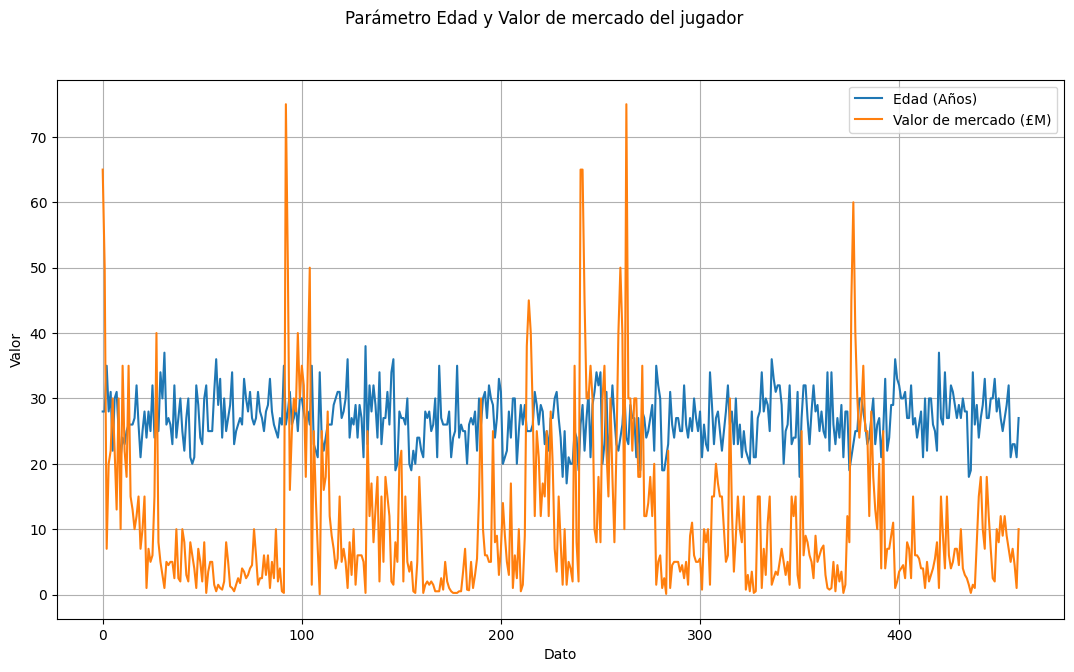

In [0]:
### Grafica los parámetros para conocer sus características: Edad y Valor de mercado

tam = len(market_value_parametro)
fig, ax1 = plt.subplots(num=None, figsize=(13,7), facecolor='w', edgecolor = 'k')
ax1.plot(range(0,tam), age_parametro, label = 'Edad (Años)')
ax1.plot(range(0,tam), market_value_parametro, label = 'Valor de mercado (£M)')
fig.suptitle('Parámetro Edad y Valor de mercado del jugador')
plt.xlabel('Dato')
plt.ylabel('Valor')
legend = ax1.legend()
plt.grid()
plt.show()

### Grafica de resultados de partidos

In [0]:
df13.createOrReplaceTempView("df13_sql")

###Se crea una consulta por cada parámetro
FTHG_parametro = spark.sql("Select FTHG from df13_sql")
FTAG_parametro = spark.sql("Select FTAG from df13_sql")

###Se convierten los resultados de la consulta a un array
FTHG_parametro = FTHG_parametro.collect()
FTHG_parametro = [ row.FTHG for row in FTHG_parametro]

FTAG_parametro = FTAG_parametro.collect()
FTAG_parametro = [ row.FTAG for row in FTAG_parametro]


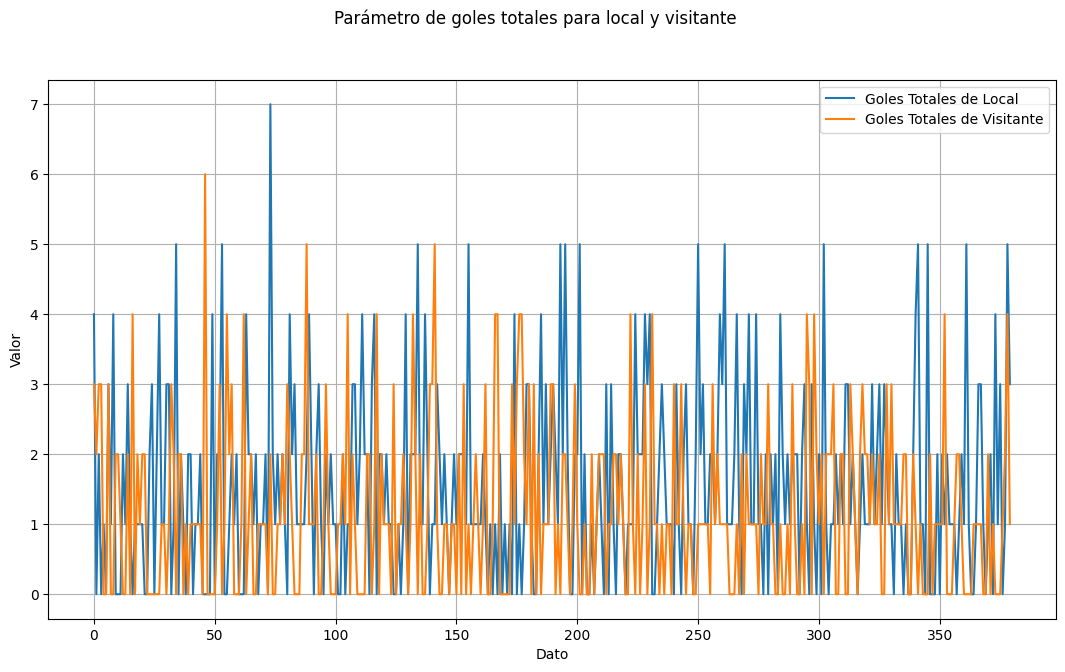

In [0]:
### Grafica los parámetros para conocer sus características: Edad y Valor de mercado

tam = len(FTHG_parametro)
fig, ax1 = plt.subplots(num=None, figsize=(13,7), facecolor='w', edgecolor = 'k')
ax1.plot(range(0,tam), FTHG_parametro, label = 'Goles Totales de Local')
ax1.plot(range(0,tam), FTAG_parametro, label = 'Goles Totales de Visitante')
fig.suptitle('Parámetro de goles totales para local y visitante')
plt.xlabel('Dato')
plt.ylabel('Valor')
legend = ax1.legend()
plt.grid()
plt.show()

### Gráfica de datos de equipos por temporada

In [0]:
df22.createOrReplaceTempView("df22_sql")

###Se crea una consulta por cada parámetro
possession_percentage_parametro = spark.sql("SELECT possession_percentage FROM df22_sql")
goals_parametro = spark.sql("SELECT goals FROM df22_sql")

###Se convierten los resultados de la consulta a un array
possession_percentage_parametro = possession_percentage_parametro.collect()
possession_percentage_parametro = [row.possession_percentage for row in possession_percentage_parametro]

goals_parametro = goals_parametro.collect()
goals_parametro = [row.goals for row in goals_parametro]

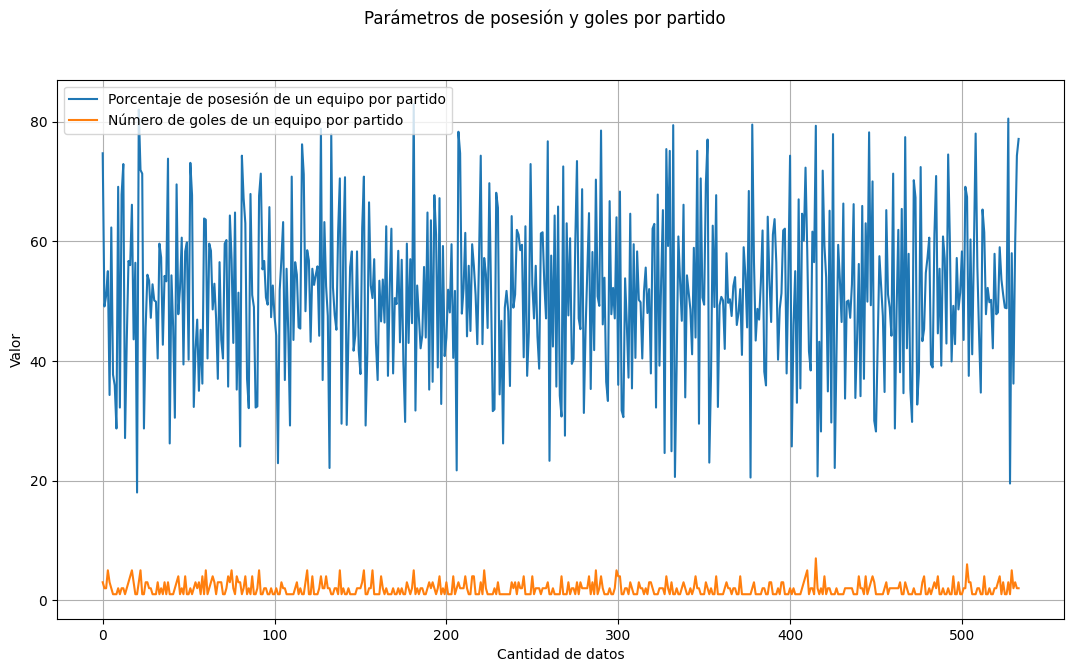

In [0]:
tam = len(possession_percentage_parametro)
fig, ax1 = plt.subplots(num= None, figsize=(13,7), facecolor='w', edgecolor='k')
ax1.plot(range(0,tam), possession_percentage_parametro, label='Porcentaje de posesión de un equipo por partido')
ax1.plot(range(0,tam), goals_parametro, label='Número de goles de un equipo por partido')
fig.suptitle('Parámetros de posesión y goles por partido')
plt.xlabel('Cantidad de datos')
plt.ylabel('Valor')
legend = ax1.legend()
plt.grid()
plt.show()

### Gráfica de datos de Jugadores por temporada

In [0]:
df32.createOrReplaceTempView("df32_sql")

player_rating_parametro = spark.sql("SELECT player_rating FROM df32_sql")
won_contest_parametro = spark.sql("SELECT won_contest FROM df32_sql")

###Se crea una consulta por cada parámetro
player_rating_parametro = player_rating_parametro.collect()
player_rating_parametro = [row.player_rating for row in player_rating_parametro]

###Se convierten los resultados de la consulta a un array
won_contest_parametro = won_contest_parametro.collect()
won_contest_parametro = [row.won_contest for row in won_contest_parametro]

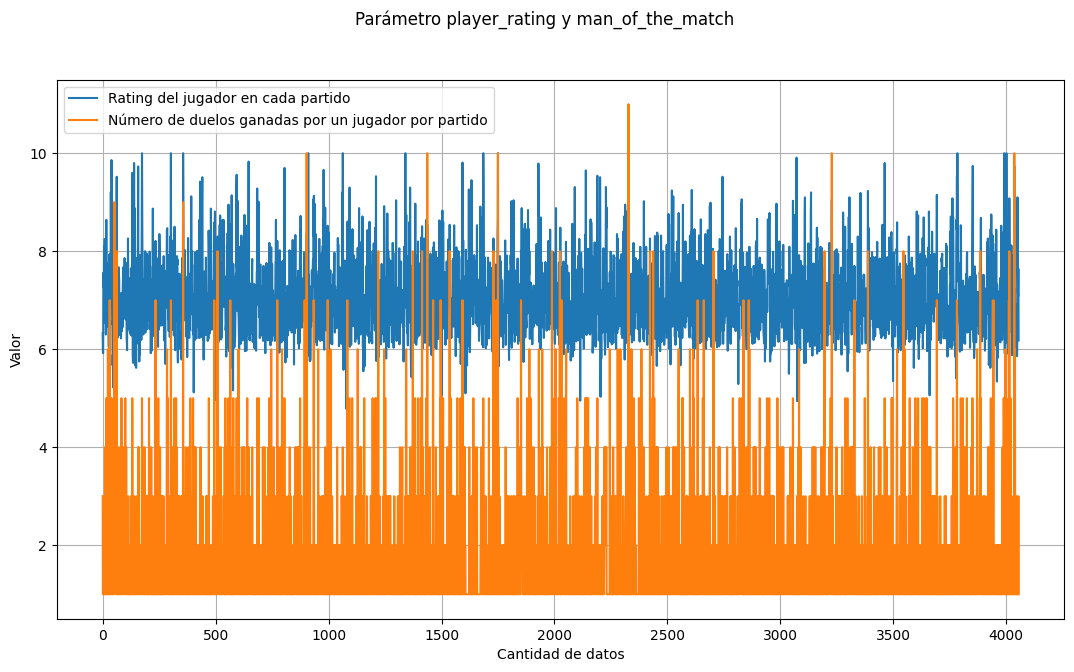

In [0]:
tam = len(won_contest_parametro)
fig, ax1 = plt.subplots(num= None, figsize=(13,7), facecolor='w', edgecolor='k')
ax1.plot(range(0,tam), player_rating_parametro, label='Rating del jugador en cada partido')
ax1.plot(range(0,tam), won_contest_parametro, label='Número de duelos ganadas por un jugador por partido')
fig.suptitle('Parámetro player_rating y man_of_the_match')
plt.xlabel('Cantidad de datos')
plt.ylabel('Valor')
legend = ax1.legend()
plt.grid()
plt.show()

# Definir calidad de rangos de datos

## Elección rangos de datos 

**Rango de datos para edades de jugadores:**

Para elegir el rango de datos de jugadores, se tomo como fuente este estudio: 
https://www.researchgate.net/publication/334219882_Effects_of_Age_on_Physical_Match_Performance_in_Professional_Soccer_Players

In [0]:
# Elegir rangos de datos para market values
df02.orderBy(col("market_value").desc()).show(50, truncate=False)

+-------------------+-----------------+---+--------+------------+---------+
|name               |club             |age|position|market_value|fpl_value|
+-------------------+-----------------+---+--------+------------+---------+
|Eden Hazard        |Chelsea          |26 |LW      |75.0        |10.5     |
|Paul Pogba         |Manchester+United|24 |CM      |75.0        |8.0      |
|Alexis Sanchez     |Arsenal          |28 |LW      |65.0        |12.0     |
|Kevin De Bruyne    |Manchester+City  |26 |AM      |65.0        |10.0     |
|Sergio Aguero      |Manchester+City  |29 |CF      |65.0        |11.5     |
|Harry Kane         |Tottenham        |23 |CF      |60.0        |12.5     |
|N%27Golo Kante     |Chelsea          |26 |DM      |50.0        |5.0      |
|Romelu Lukaku      |Manchester+United|24 |CF      |50.0        |11.5     |
|Mesut Ozil         |Arsenal          |28 |AM      |50.0        |9.5      |
|Diego Costa        |Chelsea          |28 |CF      |50.0        |10.0     |
|Raheem Ster

In [0]:
# Elegir rangos de datos para FTHG
df13.orderBy(col("FTHG").desc()).show(50, truncate=False)

+-------+--------------+--------------+----+----+---+
|Season |HomeTeam      |AwayTeam      |FTHG|FTAG|FTR|
+-------+--------------+--------------+----+----+---+
|2017-18|Man City      |Stoke         |7   |2   |H  |
|2017-18|Tottenham     |Southampton   |5   |2   |H  |
|2017-18|Arsenal       |Huddersfield  |5   |0   |H  |
|2017-18|Arsenal       |Everton       |5   |1   |H  |
|2017-18|Liverpool     |Swansea       |5   |0   |H  |
|2017-18|Tottenham     |Stoke         |5   |1   |H  |
|2017-18|Crystal Palace|Leicester     |5   |0   |H  |
|2017-18|Liverpool     |Watford       |5   |0   |H  |
|2017-18|Man City      |Swansea       |5   |0   |H  |
|2017-18|Arsenal       |Burnley       |5   |0   |H  |
|2017-18|Man City      |Liverpool     |5   |0   |H  |
|2017-18|Man City      |Leicester     |5   |1   |H  |
|2017-18|Man City      |Crystal Palace|5   |0   |H  |
|2017-18|Chelsea       |Stoke         |5   |0   |H  |
|2017-18|Tottenham     |Leicester     |5   |4   |H  |
|2017-18|Watford       |Chel

In [0]:
# Elegir rangos de datos para FTAG
df13.orderBy(col("FTAG").desc()).show(50, truncate=False)

+-------+--------------+--------------+----+----+---+
|Season |HomeTeam      |AwayTeam      |FTHG|FTAG|FTR|
+-------+--------------+--------------+----+----+---+
|2017-18|Watford       |Man City      |0   |6   |A  |
|2017-18|Everton       |Arsenal       |2   |5   |A  |
|2017-18|Brighton      |Liverpool     |1   |5   |A  |
|2017-18|Southampton   |Leicester     |1   |4   |A  |
|2017-18|Brighton      |Chelsea       |0   |4   |A  |
|2017-18|West Brom     |Chelsea       |0   |4   |A  |
|2017-18|Bournemouth   |Tottenham     |1   |4   |A  |
|2017-18|Huddersfield  |West Ham      |1   |4   |A  |
|2017-18|West Ham      |Liverpool     |1   |4   |A  |
|2017-18|Watford       |Man United    |2   |4   |A  |
|2017-18|West Ham      |Man City      |1   |4   |A  |
|2017-18|Swansea       |Man City      |0   |4   |A  |
|2017-18|West Brom     |Leicester     |1   |4   |A  |
|2017-18|Tottenham     |Leicester     |5   |4   |H  |
|2017-18|Swansea       |Man United    |0   |4   |A  |
|2017-18|Watford       |Hudd

In [0]:
# Elegir rangos de datos para el porcentaje de posesión del equipo
df22.orderBy(col("possession_percentage").desc()).show(50, truncate=False)

#Para darse una mejor idea de los rangos, se incluye esta consulta para ver los valores mas comunes de la columna
df22.groupBy("possession_percentage").count().orderBy("count", ascending=False).show()

+--------+-------+-----------------+----------------+---------------------+-------------+-----+
|match_id|team_id|team_name        |team_rating     |possession_percentage|accurate_pass|goals|
+--------+-------+-----------------+----------------+---------------------+-------------+-----+
|1190485 |167    |Manchester City  |7.75571428571429|82.9                 |942          |5    |
|1190551 |167    |Manchester City  |6.94785714285714|82.0                 |905          |3    |
|1190398 |167    |Manchester City  |7.38846153846154|80.5                 |723          |3    |
|1190306 |167    |Manchester City  |6.79714285714286|79.5                 |642          |2    |
|1190301 |26     |Liverpool        |6.72714285714286|79.4                 |644          |1    |
|1190271 |167    |Manchester City  |7.58928571428571|79.3                 |814          |7    |
|1190541 |167    |Manchester City  |7.54428571428571|78.8                 |825          |4    |
|1190523 |167    |Manchester City  |7.66

In [0]:
# Elegir rangos de datos para el total de goles del equipo
df22.orderBy(col("goals").desc()).show(50, truncate=False)

+--------+-------+-----------------+----------------+---------------------+-------------+-----+
|match_id|team_id|team_name        |team_rating     |possession_percentage|accurate_pass|goals|
+--------+-------+-----------------+----------------+---------------------+-------------+-----+
|1190271 |167    |Manchester City  |7.58928571428571|79.3                 |814          |7    |
|1190204 |167    |Manchester City  |7.92785714285714|67.4                 |576          |6    |
|1190368 |30     |Tottenham        |7.31071428571429|57.0                 |408          |5    |
|1190321 |30     |Tottenham        |7.32071428571429|70.8                 |579          |5    |
|1190223 |167    |Manchester City  |7.66642857142857|66.1                 |658          |5    |
|1190384 |15     |Chelsea          |7.50214285714286|58.5                 |592          |5    |
|1190237 |167    |Manchester City  |7.62214285714286|71.9                 |656          |5    |
|1190279 |13     |Arsenal          |7.74

In [0]:
# Elegir rangos de datos para el rating del jugador por partido
df32.orderBy(col("player_rating").desc()).show(50, truncate=False)

#Para darse una mejor idea de los rangos, se incluye esta consulta para ver los valores mas comunes de la columna
df32.groupBy("player_rating").count().orderBy("count", ascending=False).show()


+-------+----+---------+-------------------------+--------------------+-------------+-----------+
|match  |team|player_id|player_name              |player_position_info|player_rating|won_contest|
+-------+----+---------+-------------------------+--------------------+-------------+-----------+
|1190327|15  |33404    |Eden Hazard              |AMC                 |10.0         |10         |
|1190398|167 |14260    |Sergio Agüero            |FW                  |10.0         |5          |
|1190391|167 |14260    |Sergio Agüero            |FW                  |10.0         |4          |
|1190384|15  |29463    |Willian                  |FWR                 |10.0         |4          |
|1190204|167 |14260    |Sergio Agüero            |FW                  |10.0         |1          |
|1190323|26  |80767    |Philippe Coutinho        |MC                  |10.0         |5          |
|1190382|15  |33404    |Eden Hazard              |FWL                 |10.0         |9          |
|1190237|167 |144711

In [0]:
# Elegir rangos de datos para la cantidad de duelos ganados del jugador por partido
df32.orderBy(col("won_contest").desc()).show(50, truncate=False)

#Para darse una mejor idea de los rangos, se incluye esta consulta para ver los valores mas comunes de la columna
df32.groupBy("won_contest").count().orderBy("count", ascending=False).show()


+-------+----+---------+------------------------+--------------------+-------------+-----------+
|match  |team|player_id|player_name             |player_position_info|player_rating|won_contest|
+-------+----+---------+------------------------+--------------------+-------------+-----------+
|1190325|29  |122980   |Arthur Masuaku          |DML                 |8.41         |11         |
|1190327|15  |33404    |Eden Hazard             |AMC                 |10.0         |10         |
|1190367|32  |25244    |Alexis Sánchez          |AML                 |9.74         |10         |
|1190310|15  |33404    |Eden Hazard             |AMC                 |9.05         |10         |
|1190336|29  |122980   |Arthur Masuaku          |DML                 |8.55         |10         |
|1190409|29  |69517    |Michail Antonio         |DML                 |8.36         |10         |
|1190382|15  |33404    |Eden Hazard             |FWL                 |10.0         |9          |
|1190430|15  |33404    |Eden H

### Definición de rangos para datos - Visualización descriptiva

In [0]:
### Basado en el paper citado, se eligen la función del rango de las edades por rendimiento de los jugadores
df03 = df02.withColumn(
    "score_age",
    F.when(df02.age < 20, 100)
     .when((df02.age >= 20) & (df02.age < 25), 90)
     .when((df02.age >= 25) & (df02.age < 30), 75)
     .when((df02.age >= 30) & (df02.age < 35), 60)
     .when(df02.age >= 35, 45)
     .otherwise(0)
)

In [0]:
### Función definida para definir el rango del rendimiento del jugador según su valor de mercado.

df03 = df03.withColumn("score_market_value", F.when((df02.market_value>=50) & (df02.market_value<=75), 100).
                       when(((df02.market_value>=45) & (df02.market_value<=50)), 80).
                       when(((df02.market_value>=35) & (df02.market_value<=45)), 60).
                       when(((df02.market_value>=25) & (df02.market_value<=35)), 40).
                       otherwise(20))

In [0]:
### Función definida para definir el rango del rendimiento del equipo segun la cantidad de goles hechos como locales.

df14 = df13.withColumn(
    "score_FTHG", 
    F.when((df13.FTHG >= 7) & (df13.FTHG <= 9), 100)
     .when((df13.FTHG >= 5) & (df13.FTHG <= 6), 80)
     .when((df13.FTHG >= 3) & (df13.FTHG <= 4), 60)
     .when(df13.FTHG == 2, 40)
     .when(df13.FTHG == 1, 20)
     .otherwise(0)
)

In [0]:
### Función definida para definir el rango del rendimiento del equipo segun la cantidad de goles hechos como visitantes.

df14 = df14.withColumn(
    "score_FTAG", 
    F.when((df14.FTAG >= 7) & (df14.FTAG <= 9), 100)
     .when((df14.FTAG >= 5) & (df14.FTAG <= 6), 80)
     .when((df14.FTAG >= 3) & (df14.FTAG <= 4), 60)
     .when(df14.FTAG == 2, 40)
     .when(df14.FTAG == 1, 20)
     .otherwise(0)
)

In [0]:
### Función definida para definir el rango del rendimiento del equipo segun el porcentaje de posesion de pelota durante el partido.

df23 = df22.withColumn(
    "score_possession_percentage",
    F.when(df22.possession_percentage > 75, 100)
     .when((df22.possession_percentage >= 60) & (df22.possession_percentage <= 75), 80)
     .when((df22.possession_percentage >= 45) & (df22.possession_percentage < 60), 60)
     .when((df22.possession_percentage >= 30) & (df22.possession_percentage < 45), 40)
     .when((df22.possession_percentage >= 15) & (df22.possession_percentage < 30), 20)
     .otherwise(0)
)

In [0]:
### Función definida para definir el rango del rendimiento del equipo segun la gantidad de goles anotados en cada partido.

df23 = df23.withColumn(
    "score_goals",
    F.when((df23.goals >= 7) & (df23.goals <= 9), 100)
     .when((df23.goals >= 5) & (df23.goals <= 6), 80)
     .when((df23.goals >= 3) & (df23.goals <= 4), 60)
     .when(df23.goals == 2, 40)
     .when(df23.goals == 1, 20)
     .otherwise(0)
)

In [0]:
### Función definida para definir el rango del rendimiento del jugador segun su rating en cada partido.

df33 = df32.withColumn(
    "score_player_rating",
    F.when(df32.player_rating > 9.5, 100)
     .when((df32.player_rating >= 8.5) & (df32.player_rating <= 9.5), 80)
     .when((df32.player_rating >= 7.5) & (df32.player_rating < 8.5), 60)
     .when((df32.player_rating >= 6.5) & (df32.player_rating < 7.5), 40)
     .when((df32.player_rating >= 5.5) & (df32.player_rating < 6.5), 20)
     .otherwise(0)
)

In [0]:
### Función definida para definir el rango del rendimiento del jugador segun su rating segun la cantidad de duelos ganados.

df33 = df33.withColumn(
    "score_won_contest",
    F.when(df33.won_contest == 1, 20)
     .when((df33.won_contest >= 2) & (df33.won_contest <= 3), 40)
     .when((df33.won_contest >= 4) & (df33.won_contest <= 5), 60)
     .when((df33.won_contest >= 6) & (df33.won_contest <= 7), 80)
     .when(df33.won_contest > 7, 100)
     .otherwise(0)
)

## Inspección general de datos

### Información de jugadores

In [0]:
df03.show()

+--------------------+-------+---+--------+------------+---------+---------+------------------+
|                name|   club|age|position|market_value|fpl_value|score_age|score_market_value|
+--------------------+-------+---+--------+------------+---------+---------+------------------+
|      Alexis Sanchez|Arsenal| 28|      LW|        65.0|     12.0|       75|               100|
|          Mesut Ozil|Arsenal| 28|      AM|        50.0|      9.5|       75|               100|
|           Petr Cech|Arsenal| 35|      GK|         7.0|      5.5|       45|                20|
|        Theo Walcott|Arsenal| 28|      RW|        20.0|      7.5|       75|                20|
|   Laurent Koscielny|Arsenal| 31|      CB|        22.0|      6.0|       60|                20|
|     Hector Bellerin|Arsenal| 22|      RB|        30.0|      6.0|       90|                40|
|      Olivier Giroud|Arsenal| 30|      CF|        22.0|      8.5|       60|                20|
|       Nacho Monreal|Arsenal| 31|      

### Información de resultados de partidos

In [0]:
df14.show()

+-------+--------------+--------------+----+----+---+----------+----------+
| Season|      HomeTeam|      AwayTeam|FTHG|FTAG|FTR|score_FTHG|score_FTAG|
+-------+--------------+--------------+----+----+---+----------+----------+
|2017-18|       Arsenal|     Leicester|   4|   3|  H|        60|        60|
|2017-18|      Brighton|      Man City|   0|   2|  A|         0|        40|
|2017-18|       Chelsea|       Burnley|   2|   3|  A|        40|        60|
|2017-18|Crystal Palace|  Huddersfield|   0|   3|  A|         0|        60|
|2017-18|       Everton|         Stoke|   1|   0|  H|        20|         0|
|2017-18|   Southampton|       Swansea|   0|   0|  D|         0|         0|
|2017-18|       Watford|     Liverpool|   3|   3|  D|        60|        60|
|2017-18|     West Brom|   Bournemouth|   1|   0|  H|        20|         0|
|2017-18|    Man United|      West Ham|   4|   0|  H|        60|         0|
|2017-18|     Newcastle|     Tottenham|   0|   2|  A|         0|        40|
|2017-18|   

### Información de equipos por partido

In [0]:
df23.show()

+--------+-------+--------------------+----------------+---------------------+-------------+-----+---------------------------+-----------+
|match_id|team_id|           team_name|     team_rating|possession_percentage|accurate_pass|goals|score_possession_percentage|score_goals|
+--------+-------+--------------------+----------------+---------------------+-------------+-----+---------------------------+-----------+
| 1190418|     26|           Liverpool|7.22285714285714|                 74.7|          809|    3|                         80|         60|
| 1190424|    211|            Brighton|7.15384615384615|                 49.1|          300|    2|                         60|         40|
| 1190424|    183|         Bournemouth|6.90285714285714|                 50.9|          329|    2|                         60|         40|
| 1190356|     26|           Liverpool|7.84428571428572|                 55.0|          530|    5|                         60|         80|
| 1190430|    183|         

### Información de jugadores por partido

In [0]:
df33.show()

+-------+----+---------+-------------------+--------------------+-------------+-----------+-------------------+-----------------+
|  match|team|player_id|        player_name|player_position_info|player_rating|won_contest|score_player_rating|score_won_contest|
+-------+----+---------+-------------------+--------------------+-------------+-----------+-------------------+-----------------+
|1190418| 166|   136896|Florent Hadergjonaj|                  DR|         6.33|          3|                 20|               40|
|1190418| 166|   318153|         Aaron Mooy|                  MC|         5.95|          1|                 20|               20|
|1190418| 166|    82593|      Jonathan Hogg|                  MC|         5.92|          1|                 20|               20|
|1190418|  26|     4511|       James Milner|                  MC|         7.56|          1|                 60|               20|
|1190418|  26|   108226|      Mohamed Salah|                 FWR|         7.38|          3

# 6. Presentación de hallazgos encontrados en el estudio de los datos.

## a. Edades vs Valor de mercado

In [0]:
## Comparación del coste de los jugadores segun el rango de edad

df03.groupBy("score_age") \
    .agg(F.sum("market_value").alias("total_market_value")) \
    .orderBy(F.desc("total_market_value")) \
    .show()

+---------+------------------+
|score_age|total_market_value|
+---------+------------------+
|       75|           2951.15|
|       90|            1350.1|
|       60|             706.3|
|      100|             50.25|
|       45|             18.75|
+---------+------------------+



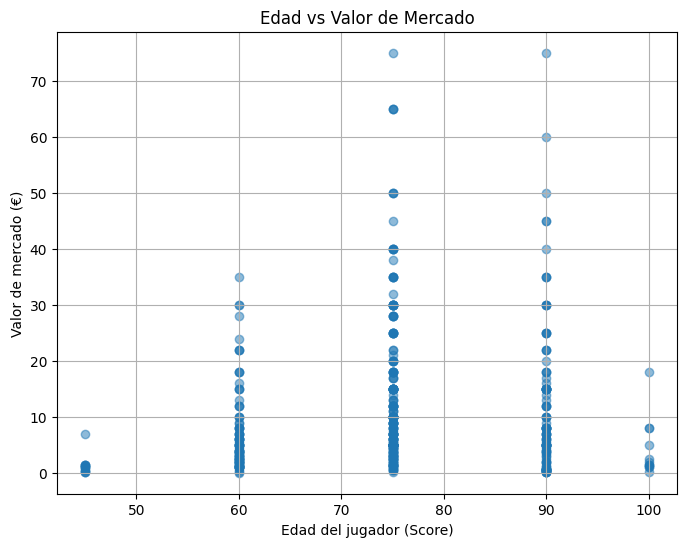

In [0]:
df_plot = df03.select("score_age", "market_value")
df_plot_pd = df_plot.toPandas()
plt.figure(figsize=(8,6))
plt.scatter(df_plot_pd["score_age"], df_plot_pd["market_value"], alpha=0.5)
plt.title("Edad vs Valor de Mercado")
plt.xlabel("Edad del jugador (Score)")
plt.ylabel("Valor de mercado (€)")
plt.grid(True)
plt.show()

El análisis muestra que los jugadores con mayor valor de mercado se concentran principalmente en el rango de 25 a 30 años, seguido por el rango de 20 a 25 años. Esto refleja que, en términos de mercado, los clubes valoran más a los jugadores que combinan plena madurez futbolística con un horizonte de carrera todavía largo.

Por el contrario, los jugadores menores de 20 años, aunque suelen destacar por su condición física y proyección, tienen un valor de mercado menor, ubicándose solo por encima de los jugadores mayores de 35 años, cuyo valor disminuye debido a la cercanía del retiro.

### Posesión vs goles

In [0]:
df23.groupBy("score_possession_percentage") \
  .agg(F.sum("goals").alias("total_goals")) \
  .orderBy(F.desc("total_goals")) \
  .show()

+---------------------------+-----------+
|score_possession_percentage|total_goals|
+---------------------------+-----------+
|                         60|        421|
|                         80|        256|
|                         40|        244|
|                        100|         55|
|                         20|         42|
+---------------------------+-----------+



El análisis evidencia que los equipos con una posesión de balón en el rango de 45% a 60% son los que logran anotar la mayor cantidad de goles, lo que sugiere que mantener una posesión equilibrada es más efectivo que dominar completamente el balón.

De manera interesante, se observa que los equipos con posesiones superiores al 75% no convierten esa superioridad en goles, lo que indica que un mayor control de la pelota no siempre se traduce en mayor capacidad ofensiva. Esto podría deberse a estilos de juego más conservadores o a la dificultad de romper defensas muy replegadas.

### Local vs Visitante

In [0]:
### Mejores equipos locales
df14.groupBy("HomeTeam") \
    .agg(
        F.sum("Score_FTHG").alias("total_home_goals_score"),
        F.sum(F.when(F.col("FTR") == "H", 1).otherwise(0)).alias("home_wins")
    ) \
    .orderBy(F.desc("home_wins")) \
    .show()

+--------------+----------------------+---------+
|      HomeTeam|total_home_goals_score|home_wins|
+--------------+----------------------+---------+
|      Man City|                  1060|       16|
|       Arsenal|                   960|       15|
|    Man United|                   680|       15|
|     Tottenham|                   700|       13|
|     Liverpool|                   780|       12|
|       Chelsea|                   560|       11|
|       Everton|                   540|       10|
|     Newcastle|                   420|        8|
|      Brighton|                   460|        7|
|     Leicester|                   500|        7|
|   Bournemouth|                   500|        7|
|Crystal Palace|                   560|        7|
|      West Ham|                   480|        7|
|       Watford|                   520|        7|
|       Burnley|                   320|        7|
|  Huddersfield|                   300|        6|
|       Swansea|                   320|        6|


El análisis evidencia que la efectividad como local no depende únicamente de la cantidad de goles anotados, sino también de la capacidad de transformar esas anotaciones en victorias. 

Mientras equipos como Manchester City combinan alto poder ofensivo con resultados consistentes, otros como Arsenal destacan por su volumen goleador pero no logran convertirlo en más triunfos. 

In [0]:
### Mejores equipos visitantes

df14.groupBy("AwayTeam") \
    .agg(
        F.sum("FTAG").alias("total_away_goals"),
        F.sum(F.when(F.col("FTR") == "A", 1).otherwise(0)).alias("away_wins")) \
    .orderBy(F.desc("away_wins")) \
    .show()


+--------------+----------------+---------+
|      AwayTeam|total_away_goals|away_wins|
+--------------+----------------+---------+
|      Man City|              45|       16|
|       Chelsea|              32|       10|
|     Tottenham|              34|       10|
|    Man United|              30|       10|
|     Liverpool|              39|        9|
|       Burnley|              20|        7|
|     Leicester|              31|        5|
|       Arsenal|              20|        4|
|   Bournemouth|              19|        4|
|Crystal Palace|              16|        4|
|     Newcastle|              18|        4|
|       Watford|              17|        4|
|  Huddersfield|              12|        3|
|       Everton|              16|        3|
|   Southampton|              17|        3|
|      West Ham|              24|        3|
|     West Brom|              10|        3|
|      Brighton|              10|        2|
|         Stoke|              15|        2|
|       Swansea|              11

El análisis de los partidos como visitante evidencia que Manchester City no solo dominó en casa sino también fuera, con el mejor balance ofensivo y de victorias. En contraste, equipos como Liverpool destacan por su capacidad goleadora fuera, pero no logran transformarla en triunfos, lo que revela problemas defensivos o de gestión de partidos.

Por otra parte, clubes como Burnley muestran que la eficacia puede pesar más que el volumen goleador, logrando un número respetable de victorias con pocos goles. 

### Score del jugador vs duelos ganados

In [0]:
df33.groupBy("score_player_rating") \
    .agg(F.sum("won_contest").alias("total_won_contest")) \
    .orderBy(F.desc("total_won_contest")) \
    .show()

+-------------------+-----------------+
|score_player_rating|total_won_contest|
+-------------------+-----------------+
|                 40|             3702|
|                 60|             1803|
|                 20|             1306|
|                 80|              440|
|                100|              158|
|                  0|               22|
+-------------------+-----------------+



El análisis de la relación entre el puntaje de rendimiento de los jugadores (score_player_rating) y la cantidad de duelos ganados (won_contest) evidencia que la mayor proporción de disputas exitosas se concentra en jugadores con calificaciones de rendimiento intermedio (6.5 a 8.5 puntos). Este hallazgo sugiere que los futbolistas con desempeño medio suelen desempeñar roles en el campo de juego que implican una participación más constante en acciones físicas, como la recuperación del balón o la contención defensiva.

Por el contrario, los jugadores con calificaciones más altas (Mayor a 8.5) presentan un menor número absoluto de duelos ganados. Esta situación puede explicarse por dos factores: 

- (i) su menor representación dentro de la muestra, dado que el número de jugadores de élite es reducido en comparación con el total 
- (ii) la naturaleza de sus funciones tácticas, que tienden a estar orientadas a la creación de juego o la finalización ofensiva más que a la disputa física constante.

Finalmente, los jugadores con calificaciones bajas (20 o 0 puntos) también registran bajos niveles de duelos ganados, lo que confirma una correlación entre bajo rendimiento global y menor impacto en acciones competitivas individuales.

### Seleccion de mejores jugadores

In [0]:
# Elegir el mejor jugador por posición

# Para mostrar nombre
windowSpec = Window.partitionBy("player_position_info").orderBy(F.desc("player_rating"))
# Mostrar el top 1
df_top_ratings = df33.withColumn("rank", F.row_number().over(windowSpec)) \
                     .filter(F.col("rank") == 1) \
                     .select("player_position_info", "player_name", "player_rating")

df_top_ratings.show()


+--------------------+--------------------+-------------+
|player_position_info|         player_name|player_rating|
+--------------------+--------------------+-------------+
|                 AMC|         Eden Hazard|         10.0|
|                 AML|  Henrikh Mkhitaryan|         9.91|
|                 AMR|           Juan Mata|         9.52|
|                  DC|   César Azpilicueta|         9.13|
|                  DL| Patrick van Aanholt|         9.12|
|                 DMC|        Aaron Ramsey|          9.7|
|                 DML|Alex Oxlade Chamb...|         9.23|
|                 DMR|        Victor Moses|          8.4|
|                  DR|Trent Alexander-A...|         9.21|
|                  FW|       Sergio Agüero|         10.0|
|                 FWL|          Leroy Sané|         10.0|
|                 FWR|          Leroy Sané|         10.0|
|                  GK|           Petr Cech|         8.15|
|                  MC|   Philippe Coutinho|         10.0|
|             